<a href="https://colab.research.google.com/github/Shubham2004yadav/temp/blob/main/LLPS_vs_non_LLPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Zhou-Yetong/Opt_PredLLPS.git

fatal: destination path 'Opt_PredLLPS' already exists and is not an empty directory.


In [2]:
!ls Opt_PredLLPS/datasets
!pip install biopython

Ind_Test_II_N.fasta  LLPS.fasta       PdPS_N.fasta	 SaPS_N.fasta
Ind_Test_II_P.fasta  LLPS_Part.fasta  PdPS_P.fasta	 SaPS_P.fasta
Ind_Test_I_N.fasta   LLPS_Self.fasta  PdPS_Test_N.fasta  SaPS_Test_N.fasta
Ind_Test_I_P.fasta   non_LLPS.fasta   PdPS_Test_P.fasta  SaPS_Test_P.fasta


In [3]:
!git clone https://github.com/Zhou-Yetong/Opt_PredLLPS.git


fatal: destination path 'Opt_PredLLPS' already exists and is not an empty directory.


In [4]:
!ls Opt_PredLLPS/datasets


Ind_Test_II_N.fasta  LLPS.fasta       PdPS_N.fasta	 SaPS_N.fasta
Ind_Test_II_P.fasta  LLPS_Part.fasta  PdPS_P.fasta	 SaPS_P.fasta
Ind_Test_I_N.fasta   LLPS_Self.fasta  PdPS_Test_N.fasta  SaPS_Test_N.fasta
Ind_Test_I_P.fasta   non_LLPS.fasta   PdPS_Test_P.fasta  SaPS_Test_P.fasta


In [5]:
from Bio import SeqIO
import pandas as pd

# Load LLPS (positive) sequences
llps_records = list(SeqIO.parse("Opt_PredLLPS/datasets/LLPS.fasta", "fasta"))

# Load non-LLPS (negative) sequences
non_llps_records = list(SeqIO.parse("Opt_PredLLPS/datasets/non_LLPS.fasta", "fasta"))


In [6]:
# Convert to DataFrame
llps_df = pd.DataFrame({
    'sequence': [str(rec.seq) for rec in llps_records],
    'label': ['LLPS'] * len(llps_records)
})

non_llps_df = pd.DataFrame({
    'sequence': [str(rec.seq) for rec in non_llps_records],
    'label': ['non-LLPS'] * len(non_llps_records)
})

# Combine both
df = pd.concat([llps_df, non_llps_df], ignore_index=True)
df.sample(5)  # View random 5 rows


,sequence,label
1068,MGLPLTFDDNNQCLLLLDSDIFTSIEAKDDIWLLNGMIIPLSPVCG...,non-LLPS
852,MKIYIQPLSVNSHTVEVLANSLPKIFNAEVFVLPASDVSLKCYNAS...,non-LLPS
805,MIYGIGTDIVSLKRIIRLNKKFGQAFAGRILTPEELLEFPQAGKPV...,non-LLPS
27,MFGNTGGGGLFGNTQTQQTGGGLFGQPQQTQFGQTGATGGGLFGGA...,LLPS
1165,MRWYPWLRPDFEKLVASYQAGRGHHALLIQALPGMGDDALIYALSR...,non-LLPS


In [7]:
!pip install biopython


In [8]:

from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Define amino acid volume (Å^3) and polarity (Grantham scale) dictionaries
aa_volume = {
    'A':  88.6, 'R': 173.4, 'N': 114.1, 'D': 111.1, 'C': 108.5,
    'Q': 143.8, 'E': 138.4, 'G':  60.1, 'H': 153.2, 'I': 166.7,
    'L': 166.7, 'K': 168.6, 'M': 162.9, 'F': 189.9, 'P':  112.7,
    'S':  89.0, 'T':  116.1, 'W': 227.8, 'Y': 193.6, 'V':  140.0
}
aa_polarity = {
    'A':   8.1, 'R':  10.5, 'N':  11.6, 'D':  13.0, 'C':   5.5,
    'Q':  10.5, 'E':  12.3, 'G':   9.0, 'H':  10.4, 'I':   5.2,
    'L':   4.9, 'K':  11.3, 'M':   5.7, 'F':   5.2, 'P':   8.0,
    'S':   9.2, 'T':   8.6, 'W':   5.4, 'Y':   6.2, 'V':   5.9
}

def compute_features(seq):
    """Compute selected features for a protein sequence."""
    seq = seq.upper()
    analysis = ProteinAnalysis(seq)
    # Calculate features
    hydrophobicity = analysis.gravy()
    aromaticity = analysis.aromaticity()
    pI = analysis.isoelectric_point()
    net_charge = analysis.charge_at_pH(7.0)
    # Average side-chain volume and polarity
    vol = sum(aa_volume.get(aa, 0) for aa in seq) / len(seq)
    pol = sum(aa_polarity.get(aa, 0) for aa in seq) / len(seq)
    return pd.Series({
        'hydrophobicity': hydrophobicity,
        'aromaticity':    aromaticity,
        'pI':             pI,
        'net_charge':     net_charge,
        'volume':         vol,
        'polarity':       pol
    })

# Apply to each sequence
features_df = df['sequence'].apply(compute_features)
df = pd.concat([df, features_df], axis=1)
df.head()


,sequence,label,hydrophobicity,aromaticity,pI,net_charge,volume,polarity
0,MNRYLNRQRLYNMEEERNKYRGVMEPMSRMTMDFQGRYMDSQGRMV...,LLPS,-1.531073,0.172316,7.219711,1.206412,141.622316,8.865254
1,MADDEQFSLCWNNFNTNLSAGFHESLCRGDLVDVSLAAEGQIVKAH...,LLPS,-0.676471,0.052941,5.360792,-13.461000,128.677059,8.864902
2,MKRPKILSGKKKSWFCMASVFLLVVAFALSIVSNAMAATGSFDRES...,LLPS,-0.057539,0.058634,4.471774,-49.193444,120.860825,8.510438
3,MKFCLSVALLAVAMVMVNGQFFGAGPFNTAHHSAVSDAAAAHHDAA...,LLPS,-0.317098,0.103627,6.210365,-8.147830,122.208290,8.559067
4,SSATNRVSPTRSVLPANWRQELESLRNGNGSSSAASSAPAPARSSS...,LLPS,-0.753052,0.037559,11.615801,16.474254,117.691549,8.880282


In [9]:
df['label_enc'] = df['label'].map({'LLPS': 1, 'non-LLPS': 0})


In [10]:
X = df[['hydrophobicity','volume','polarity','aromaticity','pI','net_charge']]
y = df['label_enc']


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Optional: detailed classification report
print(classification_report(y_test, y_pred, target_names=['non-LLPS','LLPS']))


Accuracy on test set: 0.73
Confusion matrix:
 [[121  39]
 [ 46 114]]
              precision    recall  f1-score   support

    non-LLPS       0.72      0.76      0.74       160
        LLPS       0.75      0.71      0.73       160

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



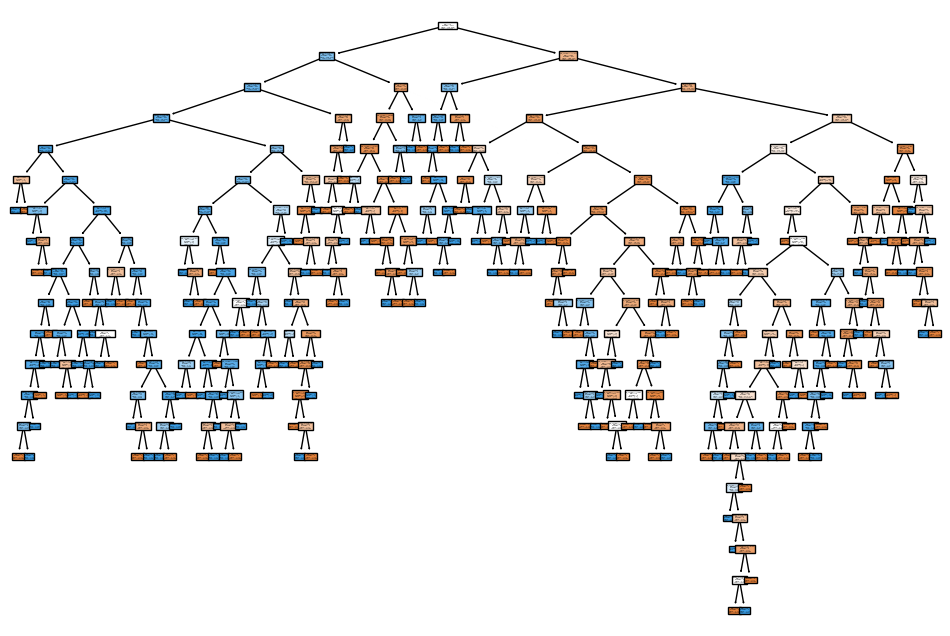

In [14]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(12,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=['non-LLPS','LLPS'], filled=True)
plt.show()
